In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2023-09-26 11:56:06.497200: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /root/miniconda3/lib/python3.8/site-packages/cv2/../../lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-09-26 11:56:06.497230: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
df = pd.read_csv("full_df.csv")
df.head(3)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg


In [3]:
#去掉年龄太大或者太小的
dfs = df[df['Patient Age'].map(lambda x:10<=x<=80)]

In [4]:
def has_glaucoma(text):
    if "glaucoma" in text:
        return 1
    else:
        return 0
dfs["left_glaucoma"] = dfs["Left-Diagnostic Keywords"].apply(lambda x: has_glaucoma(x))
dfs["right_glaucoma"] = dfs["Right-Diagnostic Keywords"].apply(lambda x: has_glaucoma(x))
left_glaucoma = dfs.loc[(dfs.G ==1) & (dfs.left_glaucoma == 1)]["Left-Fundus"].values
right_glaucoma = dfs.loc[(dfs.G ==1) & (dfs.right_glaucoma == 1)]["Right-Fundus"].values
def has_retinopathy(text):
    if "retinopathy" in text:
        return 1
    else:
        return 0
dfs["left_retinopathy"] = dfs["Left-Diagnostic Keywords"].apply(lambda x: has_retinopathy(x))
dfs["right_retinopathy"] = dfs["Right-Diagnostic Keywords"].apply(lambda x: has_retinopathy(x))
left_retinopathy = dfs.loc[(dfs.D ==1) & (dfs.left_retinopathy == 1)]["Left-Fundus"].sample(300,random_state=42).values
right_retinopathy = dfs.loc[(dfs.D ==1) & (dfs.right_retinopathy == 1)]["Right-Fundus"].sample(300,random_state=42).values
def has_cataract(text):
    if "cataract" in text:
        return 1
    else:
        return 0
dfs["left_cataract"] = dfs["Left-Diagnostic Keywords"].apply(lambda x: has_cataract(x))
dfs["right_cataract"] = dfs["Right-Diagnostic Keywords"].apply(lambda x: has_cataract(x))
left_cataract = dfs.loc[(dfs.C ==1) & (dfs.left_cataract == 1)]["Left-Fundus"].values
right_cataract = dfs.loc[(dfs.C ==1) & (dfs.right_cataract == 1)]["Right-Fundus"].values   

glaucoma = np.concatenate((left_glaucoma,right_glaucoma),axis=-1)
retinopathy = np.concatenate((left_retinopathy,right_retinopathy),axis=-1)
cataract = np.concatenate((left_cataract,right_cataract),axis=-1)
# 创建标签数组
labels = np.concatenate((np.zeros(len(glaucoma)), np.ones(len(retinopathy)), np.full(len(cataract), 2)))
labels = labels.astype(int)
# 创建数据数组
data = np.concatenate((glaucoma, retinopathy, cataract))

# 创建DataFrame
df = pd.DataFrame({'Data': data, 'Label': labels})
res = df.sample(n = len(df))
train = res.iloc[:int(len(res)*0.7)]
val = res.iloc[int(len(res)*0.7):int(len(res)*0.9)]
test = res.iloc[int(len(res)*0.9):]
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os
import pandas as pd
import numpy as np
from tqdm import tqdm

dataset_dir = "preprocessed_images/"
image_size = 224

def create_dataset(df):
    dataset = []
    for index, row in tqdm(df.iterrows(), total=df.shape[0]):
        image_path = os.path.join(dataset_dir, row[0])
        try:
            image = load_img(image_path, target_size=(image_size, image_size))
            image_array = img_to_array(image)
            label = np.array(row[1])
            dataset.append([image_array, label])
        except:
            continue
    
    np.random.shuffle(dataset)
    return dataset

/tmp/ipykernel_1843/3439892365.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs["left_glaucoma"] = dfs["Left-Diagnostic Keywords"].apply(lambda x: has_glaucoma(x))
/tmp/ipykernel_1843/3439892365.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs["right_glaucoma"] = dfs["Right-Diagnostic Keywords"].apply(lambda x: has_glaucoma(x))
/tmp/ipykernel_1843/3439892365.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

In [5]:
train_data = create_dataset(train)

100%|██████████| 1199/1199 [00:06<00:00, 179.85it/s]


In [6]:
test_data = create_dataset(test)

100%|██████████| 172/172 [00:00<00:00, 228.25it/s]


In [7]:
val_data = create_dataset(val)

100%|██████████| 342/342 [00:01<00:00, 226.71it/s]


In [8]:
x_train = np.array([i[0] for i in train_data]).reshape(-1,image_size,image_size,3)
y_train = np.array([i[1] for i in train_data])

In [9]:
x_test = np.array([i[0] for i in test_data]).reshape(-1,image_size,image_size,3)
y_test = np.array([i[1] for i in test_data])

In [10]:
x_val = np.array([i[0] for i in val_data]).reshape(-1,image_size,image_size,3)
y_val = np.array([i[1] for i in val_data])

In [11]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# 对标签数据进行独热编码
y_train_encoded = to_categorical(y_train, num_classes=3)
y_test_encoded = to_categorical(y_test, num_classes=3)
y_val_encoded = to_categorical(y_val, num_classes=3)

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function=preprocess_input
)

In [13]:
train_generator = datagen.flow(x_train, y_train_encoded, batch_size=32)

In [14]:
x_test = preprocess_input(x_test)

In [15]:
print("训练集大小:", x_train.shape[0])
print("测试集大小:", x_test.shape[0])

训练集大小: 1187
测试集大小: 172


In [16]:
from tensorflow.keras.applications.xception import Xception
xception = Xception(weights="imagenet", include_top=False, input_shape=(image_size, image_size, 3))

2023-09-26 11:56:33.243441: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2023-09-26 11:56:33.306656: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:d5:00.0 name: NVIDIA RTX A4000 computeCapability: 8.6
coreClock: 1.56GHz coreCount: 48 deviceMemorySize: 15.74GiB deviceMemoryBandwidth: 417.29GiB/s
2023-09-26 11:56:33.306893: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /root/miniconda3/lib/python3.8/site-packages/cv2/../../lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-09-26 11:56:33.307044: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcublas.so.10'; dlerror: libcublas.so.10: cannot open shared object file: No such file or direct

In [17]:
for layer in xception.layers:
    layer.trainable = False

In [18]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense
model = Sequential()
model.add(xception)
model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dense(3, activation="softmax")) 

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               25690368  
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 771       
Total params: 46,552,619
Trainable params: 25,691,139
Non-trainable params: 20,861,480
_________________________________________________________________


In [20]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(), loss="categorical_crossentropy", metrics=["accuracy"])

In [21]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint("xception.h5.h5", monitor="val_acc", verbose=1, save_best_only=True,
                             save_weights_only=False, period=1)
earlystop = EarlyStopping(monitor="val_acc", patience=5, verbose=1)

In [22]:
# 使用独热编码后的标签进行模型训练
batch_size = 32
history = model.fit_generator(train_generator, steps_per_epoch=len(x_train) // batch_size,
                              epochs=16, validation_data=(x_val, y_val_encoded),
                              verbose=1, callbacks=[checkpoint, earlystop])


Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/16
37/37 [==============================] - 92s 2s/step - loss: 70.9144 - accuracy: 0.3853 - val_loss: 252.4674 - val_accuracy: 0.3097
Epoch 2/16
37/37 [==============================] - 89s 2s/step - loss: 1.1685 - accuracy: 0.3896 - val_loss: 185.6728 - val_accuracy: 0.3068
Epoch 3/16
37/37 [==============================] - 90s 2s/step - loss: 1.4431 - accuracy: 0.3784 - val_loss: 82.2812 - val_accuracy: 0.3628
Epoch 4/16
37/37 [==============================] - 90s 2s/step - loss: 1.1146 - accuracy: 0.3792 - val_loss: 82.6621 - val_accuracy: 0.2979
Epoch 5/16
37/37 [==============================] - 90s 2s/step - loss: 1.0680 - accuracy: 0.3740 - val_loss: 82.8713 - val_accuracy: 0.3392
Epoch 6/16
37/37 [==============================] - 89s 2s/step - loss: 1.0754 - accuracy: 0.3905 - val_loss: 81.2421 - val_accuracy: 0.3127
Epoch 7/16
37/37 [==============================] - 90s 2s/step - loss: 1.0

In [23]:
loss1, accuracy1 = model.evaluate(x_train, y_train_encoded)
print("Loss:", loss1)
print("Accuracy:", accuracy1)

38/38 [==============================] - 64s 2s/step - loss: 89.9790 - accuracy: 0.3395
Loss: 89.97895050048828
Accuracy: 0.33951136469841003


In [24]:
loss2, accuracy2 = model.evaluate(x_test, y_test_encoded)
print("Loss:", loss2)
print("Accuracy:", accuracy2)

6/6 [==============================] - 8s 1s/step - loss: 0.9225 - accuracy: 0.5988
Loss: 0.9224683046340942
Accuracy: 0.5988371968269348


In [25]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
y_pred = model.predict_classes(x_val)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [26]:
accuracy_score(y_val,y_pred)

0.3333333333333333

In [27]:
print(classification_report(y_val,y_pred))

              precision    recall  f1-score   support

           0       0.86      0.05      0.09       122
           1       0.22      0.09      0.12       116
           2       0.34      0.96      0.50       101

    accuracy                           0.33       339
   macro avg       0.47      0.37      0.24       339
weighted avg       0.48      0.33      0.23       339



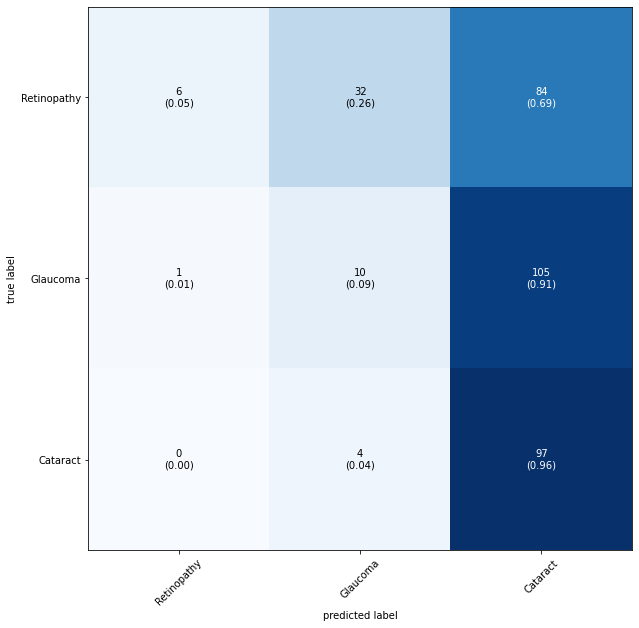

In [28]:
from mlxtend.plotting import plot_confusion_matrix
cm = confusion_matrix(y_val,y_pred)
plot_confusion_matrix(conf_mat = cm,figsize=(10,10),class_names = ["Retinopathy","Glaucoma","Cataract"],
                      show_normed = True);

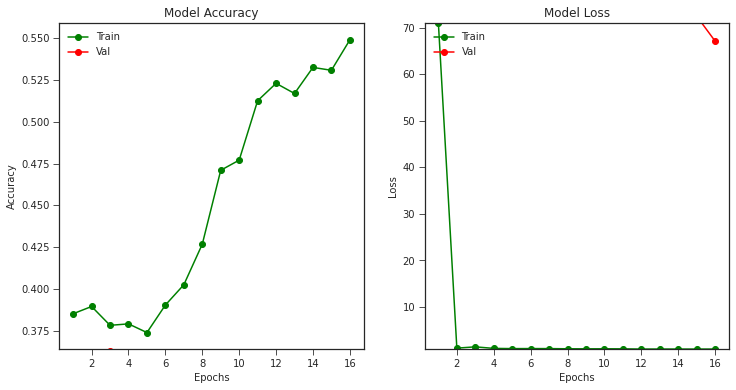

In [29]:
plt.style.use("seaborn-ticks")
fig = plt.figure(figsize=(12,6))
epochs = range(1,17)
plt.subplot(1,2,1)
plt.plot(epochs,history.history["accuracy"],"go-")
plt.plot(epochs,history.history["val_accuracy"],"ro-")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.ylim([min(history.history["accuracy"])-0.01,max(history.history["accuracy"])+0.01])
plt.legend(["Train","Val"],loc = "upper left")

plt.subplot(1,2,2)
plt.plot(epochs,history.history["loss"],"go-")
plt.plot(epochs,history.history["val_loss"],"ro-")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.ylim([min(history.history["loss"])-0.05,max(history.history["loss"])+0.05])
plt.legend(["Train","Val"],loc = "upper left")
plt.show()

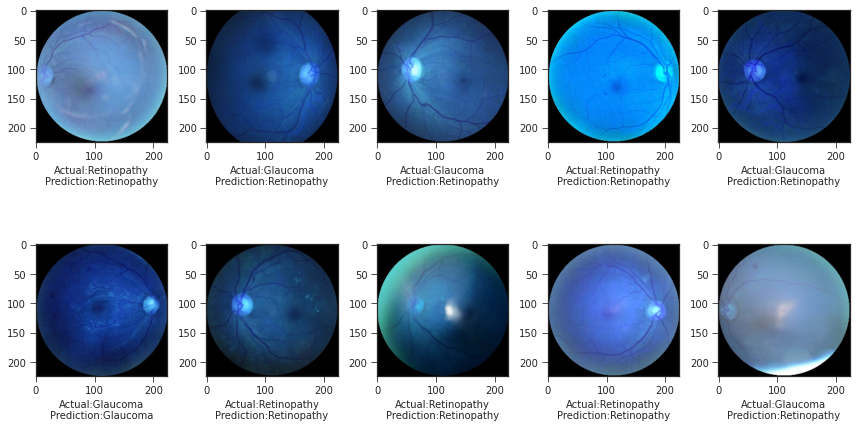

In [41]:
#plt.style.use("seaborn-ticks")
#plt.figure(figsize=(12,7))
#for i in range(10):
    #sample = random.choice(range(len(x_test)))
    #image = x_test[sample]
    #category = y_test[sample]
    #pred_category = y_pred[sample]
    
    #if category== 0:
        #label = "Retinopathy"
    #else:
        #label = "Glaucoma"
        
    #if pred_category== 0:
        #pred_label = "Retinopathy"
    #else:
        #pred_label = "Glaucoma"
        
    #plt.subplot(2,5,i+1)
    #plt.imshow(image)
    #plt.xlabel("Actual:{}\nPrediction:{}".format(label,pred_label))
#plt.tight_layout() 